# Northwind Satış Dinamiklerini Anlamak: Bir Makine Öğrenmesi Projesi

### 👩🏼‍💻 Elif Duymaz Yılmaz 👩🏼‍💻 Zeynep Öktem Kaygusuz 👩🏼‍💻 Merve Ceylan | PAIR 3
 
### 🧾 Proje Özeti

Bu projede, **Northwind veritabanındaki sipariş verileri** kullanılarak müşteri satın alma davranışı analiz edilmiştir.  
Amaç, bir müşterinin **önümüzdeki 60 gün içinde tekrar sipariş verip vermeyeceğini tahmin etmek** ve bu doğrultuda öngörücü bir model oluşturmaktır.

Proje aşağıdaki adımları içermektedir:

- 📌 **Özellik Mühendisliği**: Zaman bazlı göstergeler, sipariş sıklığı, harcama yoğunluğu, kargo gecikmesi ve etkileşim değişkenleri oluşturulmuştur.  
- 📦 **Feature Cross Oluşturma**: En sık kullanılan kargo firması, çalışan, tedarikçi ve alışveriş ayı–ülke kombinasyonları gibi çapraz özellikler eklenmiştir.  
- 🔍 **Boyut İndirgeme**: Lasso ile seçilen önemli değişkenler PCA ile özetlenmiştir.  
- 📊 **Modelleme**: Pipeline içinde Logistic Regression kullanılmış ve model seçimi nested cross-validation yöntemiyle yapılmıştır.  
- ⚙️ **Hiperparametre Ayarı**: PCA bileşen sayısı ve modelin C parametresi için GridSearchCV uygulanmıştır.  
- 📈 **Model Değerlendirmesi**: Test verisi üzerinde **Doğruluk**, **ROC AUC**, **PRC AUC** ve **Cohen’s Kappa** gibi metriklerle analiz yapılmıştır.  
- 💾 **Model Saklama**: En iyi pipeline modeli kalıcı olarak kaydedilmiştir ve yeniden kullanılabilir yapıdadır.

Sonuç olarak, kısa vadede tekrar sipariş verme ihtimali yüksek olan müşterileri başarılı şekilde tespit edebilen, güvenilir ve yorumlanabilir bir model geliştirilmiştir.

### 🗃️ Veri Çekimi ve Hedef Değişkenin Oluşturulması

Bu bölümde, PostgreSQL Northwind veritabanından siparişler, sipariş detayları, ürünler ve müşteri tabloları birleştirilerek veriler çekilmiştir.  

Amaç, aşağıdaki bilgileri içeren birleşik bir veri seti oluşturmaktır:
- müşteri satın alma geçmişi  
- gönderim ve çalışan bilgileri  
- ürün ve tedarikçi bilgileri  
- müşterinin ülkesi  

Veri yüklendikten sonra **hedef değişken** (`y`) tanımlanmıştır:  
Eğer bir müşteri son 6 ay içinde **en az 4 sipariş vermiş** ve **1500 TL'den fazla harcama yapmışsa**, hedef değeri `1`; aksi halde `0` olarak atanmıştır.

Bu aşamada eksik veri işleme de uygulanmıştır:  
Son 6 ayda sipariş vermeyen müşterilerde `order_count` ve `total_spent` sütunlarında oluşan `NaN` değerler `0` ile değiştirilmiştir.  
Bu ön işleme adımı sayesinde, pasif müşteriler açıkça temsil edilmiş; veri setinde eksik gibi görünen ama aslında anlamlı olan durumlar (yani hiç sipariş verilmemesi) doğru şekilde modellenmiştir.

In [3]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Create a connection to the PostgreSQL database using SQLAlchemy
engine = create_engine("postgresql+psycopg2://postgres:1@localhost:5432/GYK2Northwind")

# SQL query: retrieve order details along with customer, product, shipping and employee information
query = """
SELECT 
    o.customer_id,
    o.order_id,
    o.order_date,
    o.shipped_date,
    o.ship_via,
    o.employee_id,
    od.product_id,
    p.supplier_id,
    od.unit_price,
    od.quantity,
    c.country
FROM orders o
JOIN order_details od ON o.order_id = od.order_id
JOIN products p ON od.product_id = p.product_id
JOIN customers c ON o.customer_id = c.customer_id
"""

# Execute the query and load the result into a pandas DataFrame
df = pd.read_sql(query, engine)

df.to_csv("data_output.csv", index=False)

df = pd.read_csv("output.csv")
# Convert order_date column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Calculate minimum and maximum order dates in the dataset
min_date = df['order_date'].min()
max_date = df['order_date'].max()
print("Min Date:", min_date)
print("Max Date:", max_date)

# Define cutoff date as the latest order date
cutoff_date = max_date

# Calculate the date 6 months prior to the cutoff
six_months_ago = cutoff_date - pd.DateOffset(months=6)

# Get a unique list of all customers
all_customers = df['customer_id'].unique()
all_customers_df = pd.DataFrame({'customer_id': all_customers})

# Filter orders placed within the last 6 months
recent = df[(df['order_date'] > six_months_ago) & (df['order_date'] <= cutoff_date)].copy()

# Calculate total price per line
recent['total_price'] = recent['unit_price'] * recent['quantity']

# Aggregate order count and total spending per customer
agg = recent.groupby('customer_id').agg(
    order_count=('order_id', 'nunique'),
    total_spent=('total_price', 'sum')
).reset_index()

# Merge with all customers and fill missing values with 0
agg_full = all_customers_df.merge(agg, on='customer_id', how='left')
agg_full[['order_count', 'total_spent']] = agg_full[['order_count', 'total_spent']].fillna(0)

# Define target variable: 1 if customer has 4+ orders and spent more than 1500 TL in last 6 months, else 0
agg_full['y'] = ((agg_full['order_count'] >= 4) & (agg_full['total_spent'] >= 1500)).astype(int)

# Sort by customer_id and reset the index
agg_full = agg_full.sort_values(by='customer_id').reset_index(drop=True)

# Display the first few rows of the resulting target DataFrame
display(agg_full.head())

Min Date: 1996-07-04 00:00:00
Max Date: 1998-05-06 00:00:00


,customer_id,order_count,total_spent,y
0,ALFKI,3.0,2302.20,0
1,ANATR,2.0,834.40,0
2,ANTON,1.0,660.00,0
3,AROUT,8.0,8127.60,1
4,BERGS,7.0,9666.05,1


In [ ]:
# ...existing code...
# İlk 5 satırı tablo olarak kaydet
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
tbl = ax.table(cellText=agg_full.head().values, colLabels=agg_full.columns, loc='center')
plt.savefig('img/tablo/agg_full_head.png', bbox_inches='tight', dpi=150)
plt.close()
# ...existing code...

### 🧠 Özellik Mühendisliği: X1 to X12

Bu bölümde müşteri davranışlarını yansıtan 12 özellik oluşturulmuştur:

- **X1–X3**: Son 6 / 3 / 1 ayda sipariş verip vermeme durumu
- **X4**: Son siparişten bu yana geçen gün
- **X5–X6**: Tüm zamanlar için sipariş sıklığı ve harcama yoğunluğu
- **X7–X12**: Son 6 / 3 / 1 ay için sipariş sıklığı ve harcama yoğunluğu

Tüm değişkenler `features_df` adlı tek bir veri çerçevesinde birleştirilmiştir.  
Eksik değerler sıfırla doldurulmuş ve `target` değişkeni müşteri ID'si üzerinden eklenmiştir.

In [4]:
# 1. Determine cutoff date (latest order date in the dataset)
six_months_ago = cutoff_date - pd.DateOffset(months=6)
three_months_ago = cutoff_date - pd.DateOffset(months=3)
one_month_ago = cutoff_date - pd.DateOffset(months=1)

# 2. Calculate total price per line
df['total_price'] = df['unit_price'] * df['quantity']

# 3. Aggregate per customer (entire history)
agg_all = df.groupby('customer_id').agg(
    first_order_date=('order_date', 'min'),
    last_order_date=('order_date', 'max'),
    total_orders=('order_id', 'nunique'),
    total_spent=('total_price', 'sum')
).reset_index()

agg_all['days_since_first_order'] = (cutoff_date - agg_all['first_order_date']).dt.days + 1
agg_all['days_since_last_order'] = (cutoff_date - agg_all['last_order_date']).dt.days

# 4. Helper function: binary indicator for recent orders
def has_recent_orders(m_df, since_date):
    return m_df[m_df['order_date'] > since_date].groupby('customer_id')['order_id'].nunique().gt(0).astype(int)

x1 = has_recent_orders(df, six_months_ago)
x2 = has_recent_orders(df, three_months_ago)
x3 = has_recent_orders(df, one_month_ago)

# 5. Feature X4: Days since last order
x4 = agg_all.set_index('customer_id')['days_since_last_order']

# 6. Features X5–X6: All-time order frequency and spending density
x5 = agg_all.set_index('customer_id')['total_orders'] / agg_all.set_index('customer_id')['days_since_first_order']
x6 = agg_all.set_index('customer_id')['total_spent'] / agg_all.set_index('customer_id')['days_since_first_order']

# 7. Function: recent frequency and spending density
def calculate_recent_metrics(m_df, since_date, cutoff_date):
    recent = m_df[(m_df['order_date'] > since_date) & (m_df['order_date'] <= cutoff_date)].copy()
    recent['total_price'] = recent['unit_price'] * recent['quantity']
    days = (cutoff_date - since_date).days
    agg = recent.groupby('customer_id').agg(
        recent_orders=('order_id', 'nunique'),
        recent_spent=('total_price', 'sum')
    )
    agg['freq'] = agg['recent_orders'] / days
    agg['density'] = agg['recent_spent'] / days
    return agg[['freq', 'density']]

x7_8 = calculate_recent_metrics(df, six_months_ago, cutoff_date)
x9_10 = calculate_recent_metrics(df, three_months_ago, cutoff_date)
x11_12 = calculate_recent_metrics(df, one_month_ago, cutoff_date)

# 8. Combine all features into a single DataFrame
features_df = agg_all.set_index('customer_id')[[]].copy()
features_df['X1_has_order_last_6_months'] = x1
features_df['X2_has_order_last_3_months'] = x2
features_df['X3_has_order_last_1_month'] = x3
features_df['X4_days_since_last_order'] = x4
features_df['X5_order_frequency_all_time'] = x5
features_df['X6_spending_density_all_time'] = x6
features_df['X7_order_frequency_last_6_months'] = x7_8['freq']
features_df['X8_spending_density_last_6_months'] = x7_8['density']
features_df['X9_order_frequency_last_3_months'] = x9_10['freq']
features_df['X10_spending_density_last_3_months'] = x9_10['density']
features_df['X11_order_frequency_last_1_month'] = x11_12['freq']
features_df['X12_spending_density_last_1_month'] = x11_12['density']

# 9. Fill missing values (e.g., customers with no orders in that window)
features_df = features_df.fillna(0)

# 10. Reset index if needed
features_df = features_df.reset_index()

# Merge the target variable 'y' from agg_full into the feature dataset using customer_id as key
# This approach ensures correct alignment by customer, even if the indexes differ
features_df = features_df.merge(
    agg_full[['customer_id', 'y']].rename(columns={'y': 'target'}),
    on='customer_id',
    how='right'
)

# Retrieve the current list of column names
cols = features_df.columns.tolist()

# Identify all feature columns excluding 'customer_id' and 'target'
other_cols = [col for col in cols if col not in ['customer_id', 'target']]

# Define a new column order: start with customer_id and target, followed by the features
ordered_cols = ['customer_id', 'target'] + other_cols

# Reorder the DataFrame columns accordingly
features_df = features_df[ordered_cols]

# Display the first few rows of the final feature matrix
display(features_df.head())

# Export the final features dataset to CSV for future modeling steps
features_df.to_csv("features_output.csv", index=False)

,customer_id,target,X1_has_order_last_6_months,X2_has_order_last_3_months,X3_has_order_last_1_month,X4_days_since_last_order,X5_order_frequency_all_time,X6_spending_density_all_time,X7_order_frequency_last_6_months,X8_spending_density_last_6_months,X9_order_frequency_last_3_months,X10_spending_density_last_3_months,X11_order_frequency_last_1_month,X12_spending_density_last_1_month
0,ALFKI,0,1.0,1.0,1.0,27,0.023529,18.024314,0.016575,12.719337,0.022472,16.305618,0.033333,32.000000
1,ANATR,0,1.0,1.0,0.0,63,0.006711,2.353943,0.011050,4.609945,0.011236,5.779775,0.000000,0.000000
2,ANTON,0,1.0,0.0,0.0,98,0.013308,14.287738,0.005525,3.646409,0.000000,0.000000,0.000000,0.000000
3,AROUT,1,1.0,1.0,1.0,26,0.024164,25.662639,0.044199,44.903867,0.033708,62.432584,0.033333,16.383333
4,BERGS,1,1.0,1.0,0.0,63,0.028436,42.603712,0.038674,53.403591,0.011236,22.859551,0.000000,0.000000


In [ ]:
# ...existing code...
# features_df'in ilk 5 satırını tablo olarak kaydet
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tbl = ax.table(cellText=features_df.head().values, colLabels=features_df.columns, loc='center')
plt.savefig('img/tablo/features_df_head.png', bbox_inches='tight', dpi=150)
plt.close()
# ...existing code...

### Interaction Term 1: has_order_last_6_months × avg_shipping_delay

Bu etkileşim, son dönem sipariş geçmişi ile teslimat süresi performansının birleşik etkisini yakalar. Modelin, yakın zamanda sipariş vermiş müşterilerin uzun teslimat sürelerine daha duyarlı olup olmadığını öğrenmesini sağlar.

In [5]:
# Ensure datetime format
df['shipped_date'] = pd.to_datetime(df['shipped_date'])

# Average shipping delay per customer (in days)
df['shipping_delay'] = (df['shipped_date'] - df['order_date']).dt.days
shipping_delay = df.groupby('customer_id')['shipping_delay'].mean()

shipping_delay_df = shipping_delay.reset_index()
#display(shipping_delay_df.head())

# Step 3: Güvenli çarpım
X13 = (
    features_df['X7_order_frequency_last_6_months'].fillna(0) *
    shipping_delay_df['shipping_delay'].fillna(0)
)
X13.name = 'X13_freq_last_6m_x_avg_shipping_delay'

### Interaction Term 2: order_frequency_last_6_months / order_frequency_all_time

Bu oran, müşterinin tüm satın alma geçmişine kıyasla son dönemdeki sipariş sıklığını gösterir. Modelin, müşterinin yakın zamanda daha aktif veya daha pasif hale gelip gelmediğini anlamasına yardımcı olur.

In [6]:
# Create interaction feature X14: ratio of recent order frequency (last 6 months) to all-time order frequency
# Replace any infinite values (e.g. division by zero) with 0 and fill remaining NaNs with 0
X14 = (
    features_df['X7_order_frequency_last_6_months'] /
    features_df['X5_order_frequency_all_time']
).replace([float('inf'), -float('inf')], 0).fillna(0)

# Assign a name to the new feature for future reference
X14.name = 'X14_freq_6m_div_freq_all'

### Interaction Term 3: order_frequency_all_time × spending_density_all_time

Bu etkileşim, uzun vadeli sipariş sıklığı ile sipariş başına ortalama harcamayı birleştirir. Modelin, geçmiş verilere göre yüksek sıklıkta ve yüksek tutarda alışveriş yapan müşterileri tanımlamasına yardımcı olur.

In [7]:
# Create interaction feature X15: product of all-time order frequency and all-time spending density
# Fill any missing values with 0 to ensure numerical stability
X15 = (
    features_df['X5_order_frequency_all_time'] *
    features_df['X6_spending_density_all_time']
).fillna(0)

# Assign a name to the new feature for identification
X15.name = 'X15_freq_x_density_all'

#### 📊 Interaction Term Tablosu

Aşağıdaki tablo, modelleme amacıyla oluşturulan etkileşim değişkenlerinin (interaction parameters) ilk birkaç satırını göstermektedir.

In [8]:
# Combine interaction features (X13, X14, X15) into a single DataFrame along with customer_id
# This ensures that the interaction variables remain aligned with the correct customers
interaction_df = pd.concat([features_df[['customer_id']], X13, X14, X15], axis=1).fillna(0)

# Display the first few rows of the interaction features
display(interaction_df.head())

# Export interaction features to CSV for future use
interaction_df.to_csv("interactions_output.csv", index=False)

,customer_id,X13_freq_last_6m_x_avg_shipping_delay,X14_freq_6m_div_freq_all,X15_freq_x_density_all
0,ALFKI,0.118785,0.704420,0.424101
1,ANATR,0.079558,1.646409,0.015798
2,ANTON,0.034449,0.415154,0.190141
3,AROUT,0.275506,1.829154,0.620101
4,BERGS,0.423927,1.360037,1.211480


In [ ]:
# ...existing code...
# interaction_df'in ilk 5 satırını tablo olarak kaydet
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
tbl = ax.table(cellText=interaction_df.head().values, colLabels=interaction_df.columns, loc='center')
plt.savefig('img/tablo/interaction_df_head.png', bbox_inches='tight', dpi=150)
plt.close()
# ...existing code...

### Feature Crosses 1–3: most_used_shipper × employee × supplier

Bu etkileşim değişkenleri, her müşteri için en sık ilişkilendirilen kargo firması, çalışan ve tedarikçiyi birleştirerek ilişkisel davranış kalıplarını yakalamayı amaçlar.

- `X16`: Müşterinin en çok kullandığı kargo firması ve çalışan kombinasyonu  
- `X17`: Müşterinin en çok çalıştığı tedarikçi ve çalışan kombinasyonu  
- `X18`: Müşterinin en çok kullandığı kargo firması ve tedarikçi kombinasyonu

Bu çapraz değişkenler, belirli kargo-çalışan veya tedarikçi-çalışan ikililerinin müşteri davranışı üzerindeki etkilerini modele yansıtmayı sağlar.

In [9]:
# Identify the most frequently used shipper, employee, and supplier for each customer

# 1. Most used shipper
customer_shipper = df.groupby(['customer_id', 'ship_via']).size().reset_index(name='count')
customer_shipper = customer_shipper.sort_values('count', ascending=False).drop_duplicates('customer_id')
customer_shipper = customer_shipper[['customer_id', 'ship_via']].rename(columns={'ship_via': 'most_used_shipper'})

# 2. Most used employee
customer_employee = df.groupby(['customer_id', 'employee_id']).size().reset_index(name='count')
customer_employee = customer_employee.sort_values('count', ascending=False).drop_duplicates('customer_id')
customer_employee = customer_employee[['customer_id', 'employee_id']].rename(columns={'employee_id': 'most_used_employee'})

# 3. Most used supplier
customer_supplier = df.groupby(['customer_id', 'supplier_id']).size().reset_index(name='count')
customer_supplier = customer_supplier.sort_values('count', ascending=False).drop_duplicates('customer_id')
customer_supplier = customer_supplier[['customer_id', 'supplier_id']].rename(columns={'supplier_id': 'most_used_supplier'})

# Add this information to crosses_df
crosses_df = features_df[['customer_id']].copy()
crosses_df = crosses_df.merge(customer_shipper, on='customer_id', how='left')
crosses_df = crosses_df.merge(customer_employee, on='customer_id', how='left')
crosses_df = crosses_df.merge(customer_supplier, on='customer_id', how='left')

# Create feature crosses
crosses_df['X16_cross_shipper_employee'] = (
    crosses_df['most_used_shipper'].astype(str) + "_" +
    crosses_df['most_used_employee'].astype(str)
)

crosses_df['X17_cross_supplier_employee'] = (
    crosses_df['most_used_supplier'].astype(str) + "_" +
    crosses_df['most_used_employee'].astype(str)
)

crosses_df['X18_cross_shipper_supplier'] = (
    crosses_df['most_used_shipper'].astype(str) + "_" +
    crosses_df['most_used_supplier'].astype(str)
)

### Feature Cross 4: most_common_month × customer_country

Bu etkileşim değişkeni, müşterinin en sık alışveriş yaptığı ay ile ülkesini birleştirir. Amaç, bölgesel veya mevsimsel alışveriş alışkanlıklarının, müşterinin 60 gün içinde yeniden sipariş verme olasılığı üzerindeki etkisini modele yansıtmaktır.

In [10]:
# Step 1: Extract purchase month
df['purchase_month'] = pd.to_datetime(df['order_date']).dt.month

# Step 2: Most frequent purchase month per customer (Series)
most_common_month = (
    df.groupby(['customer_id', 'purchase_month'])
    .size()
    .reset_index(name='count')
    .sort_values(['customer_id', 'count'], ascending=[True, False])
    .drop_duplicates('customer_id')
    .set_index('customer_id')['purchase_month']
)
most_common_month = most_common_month.rename('most_common_month')

# Step 3: Customer's country
customer_country = df[['customer_id', 'country']].drop_duplicates().set_index('customer_id')
customer_country = customer_country.rename(columns={'country': 'customer_country'})

# Step 4: Merge both into crosses_df
crosses_df = crosses_df.merge(most_common_month, on='customer_id', how='left')
crosses_df = crosses_df.merge(customer_country, on='customer_id', how='left')

# Step 5: Create the cross feature
crosses_df['X19_cross_month_country'] = (
    crosses_df['most_common_month'].astype(str) + "_" +
    crosses_df['customer_country'].astype(str)
)

#### 📊 Feature Crosses Tablosu

Aşağıdaki tablo, modelleme amacıyla oluşturulan feature cross değişkenlerinin ilk birkaç satırını göstermektedir.

In [11]:
display(crosses_df[['customer_id','X16_cross_shipper_employee', 'X17_cross_supplier_employee', 'X18_cross_shipper_supplier','X19_cross_month_country']].head())

,customer_id,X16_cross_shipper_employee,X17_cross_supplier_employee,X18_cross_shipper_supplier,X19_cross_month_country
0,ALFKI,1_1,12_1,1_12,8_Germany
1,ANATR,3_4,6_4,3_6,3_Mexico
2,ANTON,2_3,20_3,2_20,9_Mexico
3,AROUT,2_1,24_1,2_24,12_UK
4,BERGS,2_3,12_3,2_12,2_Sweden


In [ ]:
# ...existing code...
# crosses_df'in ilk 5 satırını tablo olarak kaydet
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tbl = ax.table(cellText=crosses_df[['customer_id','X16_cross_shipper_employee', 'X17_cross_supplier_employee', 'X18_cross_shipper_supplier','X19_cross_month_country']].head().values,
               colLabels=['customer_id','X16_cross_shipper_employee', 'X17_cross_supplier_employee', 'X18_cross_shipper_supplier','X19_cross_month_country'],
               loc='center')
plt.savefig('img/tablo/crosses_df_head.png', bbox_inches='tight', dpi=150)
plt.close()
# ...existing code...

### 🧩 Tüm Feature'ların DataFrame'e Toplanması

Bu bölümde, tüm oluşturulan değişkenler birleştirilerek nihai özellik matrisi oluşturulmuştur.  
Bu birleşim şunları içerir:
- Temel özellikler (X1–X12)  
- Etkileşimli özellikler (X13–X15)  
- Birleştirilmiş kategorik özellikler (X16–X19)

Ortaya çıkan `features_df` hem sayısal hem de kategorik değişkenleri içerir.  
Modellemeye uygun hale getirmek için string tabanlı kategorik değişkenlere one-hot encoding uygulanmıştır.  
`drop_first=True` parametresi kullanılarak her kategorik değişkenin ilk sınıfı düşürülmüş, böylece çoklu doğrusal bağlantı (multicollinearity) riski önlenmiştir.

In [12]:
# Merge all feature sets into a single DataFrame
# Combine interaction and cross features

cross_features = crosses_df[[ 
    'X16_cross_shipper_employee',
    'X17_cross_supplier_employee',
    'X18_cross_shipper_supplier',
    'X19_cross_month_country'
]]

interaction_df_new = interaction_df[[ 
    'X13_freq_last_6m_x_avg_shipping_delay',
    'X14_freq_6m_div_freq_all',
    'X15_freq_x_density_all'
]]

# Concatenate all features column-wise
features_df = pd.concat([features_df, interaction_df_new, cross_features], axis=1)
display(features_df.head())

# Export the final feature set to CSV
features_df.to_csv("features_final.csv", index=False)

# One-Hot Encoding for categorical (string-based cross) features
categorical_cols = ['X16_cross_shipper_employee', 'X17_cross_supplier_employee', 
                    'X18_cross_shipper_supplier', 'X19_cross_month_country']

# Apply one-hot encoding and drop the first category to avoid multicollinearity
features_df = pd.get_dummies(features_df, columns=categorical_cols, drop_first=True)

,customer_id,target,X1_has_order_last_6_months,X2_has_order_last_3_months,X3_has_order_last_1_month,X4_days_since_last_order,X5_order_frequency_all_time,X6_spending_density_all_time,X7_order_frequency_last_6_months,X8_spending_density_last_6_months,...,X10_spending_density_last_3_months,X11_order_frequency_last_1_month,X12_spending_density_last_1_month,X13_freq_last_6m_x_avg_shipping_delay,X14_freq_6m_div_freq_all,X15_freq_x_density_all,X16_cross_shipper_employee,X17_cross_supplier_employee,X18_cross_shipper_supplier,X19_cross_month_country
0,ALFKI,0,1.0,1.0,1.0,27,0.023529,18.024314,0.016575,12.719337,...,16.305618,0.033333,32.000000,0.118785,0.704420,0.424101,1_1,12_1,1_12,8_Germany
1,ANATR,0,1.0,1.0,0.0,63,0.006711,2.353943,0.011050,4.609945,...,5.779775,0.000000,0.000000,0.079558,1.646409,0.015798,3_4,6_4,3_6,3_Mexico
2,ANTON,0,1.0,0.0,0.0,98,0.013308,14.287738,0.005525,3.646409,...,0.000000,0.000000,0.000000,0.034449,0.415154,0.190141,2_3,20_3,2_20,9_Mexico
3,AROUT,1,1.0,1.0,1.0,26,0.024164,25.662639,0.044199,44.903867,...,62.432584,0.033333,16.383333,0.275506,1.829154,0.620101,2_1,24_1,2_24,12_UK
4,BERGS,1,1.0,1.0,0.0,63,0.028436,42.603712,0.038674,53.403591,...,22.859551,0.000000,0.000000,0.423927,1.360037,1.211480,2_3,12_3,2_12,2_Sweden


### 🔍 LassoCV ile Özellik Seçimi

Bu bölümde, bir müşterinin 60 gün içinde tekrar sipariş verip vermeyeceğini tahmin etmek için Lasso regresyonu ve çapraz doğrulama uygulanır. Lasso, önemsiz özelliklerin katsayılarını sıfıra indirerek aynı zamanda feature selection işlemi yapar.

Sonuçta modele en fazla katkı sağlayan (sıfırdan farklı katsayısı olan) değişkenler gösterilir.

In [13]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np

# 1. Define target and features
X = features_df.drop(columns=['target','customer_id'])
y = features_df['target'] 

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = lasso. predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# 5. Optional: View selected (non-zero) features
selected_features = X.columns[np.abs(lasso.coef_) > 1e-5]
print("Selected features by Lasso:")
for feature in selected_features:
    print("-", feature)

# Create a DataFrame to view all feature coefficients
lasso_coeffs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)

print(lasso_coeffs.head(8))

Accuracy: 0.7777777777777778
ROC AUC: 0.8472222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.67      0.80        12

    accuracy                           0.78        18
   macro avg       0.80      0.83      0.78        18
weighted avg       0.87      0.78      0.78        18

Selected features by Lasso:
- X3_has_order_last_1_month
- X4_days_since_last_order
- X8_spending_density_last_6_months
- X10_spending_density_last_3_months
- X12_spending_density_last_1_month
- X14_freq_6m_div_freq_all
                                feature  coefficient
2             X3_has_order_last_1_month     0.170314
13             X14_freq_6m_div_freq_all     0.159196
7     X8_spending_density_last_6_months     0.002324
9    X10_spending_density_last_3_months     0.001415
3              X4_days_since_last_order    -0.001052
11    X12_spending_density_last_1_month    -0.000780
1

### 📈 LassoCV Sonuçları ve Özellik Seçimi

Bu Lasso modeli, 60 gün içinde tekrar sipariş verip vermeme durumunu tahmin ederken %77.8 doğruluk ve 0.85 ROC AUC skoru elde etmiştir.  
Bu, modelin genel olarak sınıflandırma görevinde başarılı olduğunu göstermektedir.

Sınıflandırma raporuna göre:
- Sınıf 0 için %100 recall: tekrar sipariş vermeyen müşteriler tam olarak doğru tahmin edilmiştir.
- Sınıf 1 için yüksek precision: modelin tekrar sipariş verecek dediği müşteriler çoğunlukla doğru çıkmıştır.
- Ancak sınıf 1 için **recall düşük kalmıştır**, yani model bazı gerçek tekrar sipariş verenleri kaçırmaktadır — bu durum, bu aşamada beklenen bir sınırlılıktır.

Lasso modeli sıfırdan farklı katsayıya sahip 6 özelliği seçmiştir.  
Özellikle öne çıkanlar:
- `X3` ve `X4`: son zamanlardaki müşteri hareketlerini temsil eder.
- `X8`, `X10`, `X12`: son zamanlardaki harcama yoğunluğunu gösterir.
- `X14`: kısa dönem / uzun dönem sipariş oranını göstererek son dönemde daha aktif müşterileri yakalar. 

### 🧬 PSeçilen Özellikler için PCA Görselleştirmesi

Seçilen özelliklerin düşük boyutlarda görselleştirilebilmesi için PCA (Principal Component Analysis) uygulanmıştır.  
Ölçeklenmiş eğitim verisi, 2 ve 3 boyutlu uzaylara yansıtılmış ve sınıflar arasındaki ayrım görsel olarak incelenmiştir.

- **2 boyutlu görselleştirme**: ilk iki ana bileşen kullanılarak yapılmıştır.  
- **3 boyutlu görselleştirme**: ilk üç ana bileşen temel alınarak yapılmıştır.

Ayrıca, her projeksiyonda açıklanan varyans oranları da belirtilmiştir. Bu oranlar, veri setindeki toplam varyansın ne kadarının yakalandığını göstermektedir.

Görsellerde renk kodlaması hedef sınıfa (`0` veya `1`) göre yapılmış ve bu sayede seçilen değişkenlerin sınıf ayrımına katkısı görsel olarak analiz edilmiştir.

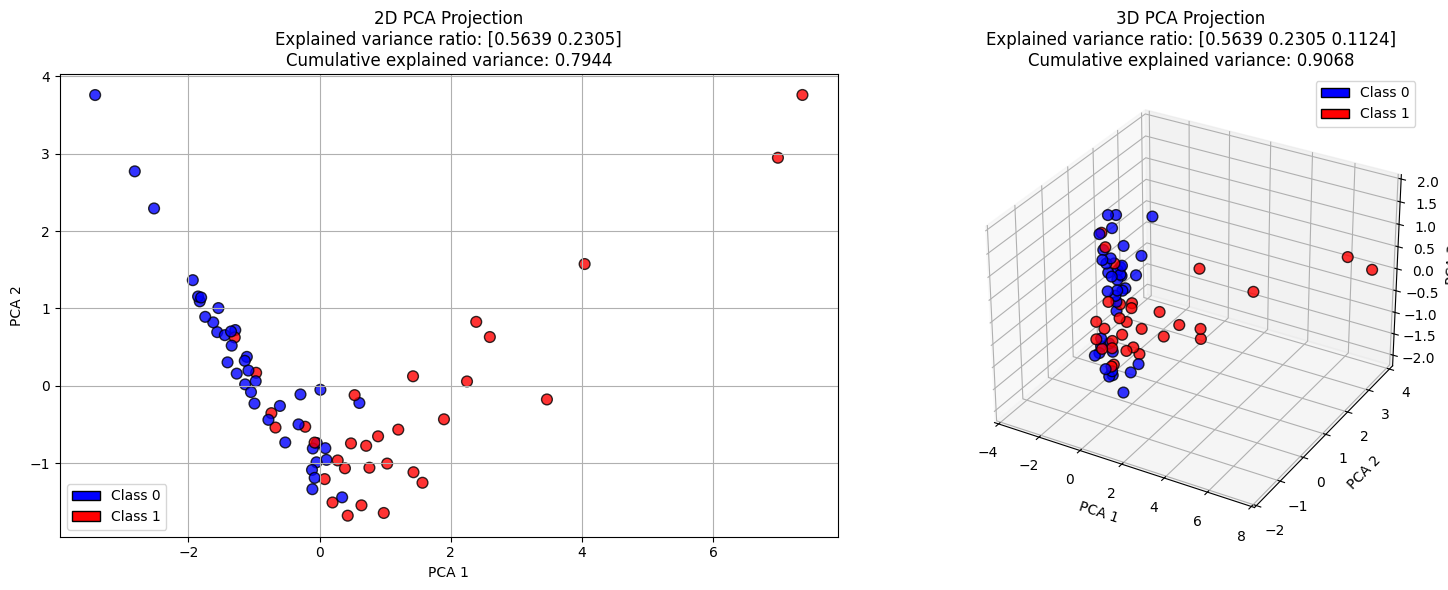

In [14]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Scale the selected features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_train[selected_features])

# 2. PCA for 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_selected_scaled)
explained_ratio_2 = pca_2.explained_variance_ratio_
cumulative_2 = explained_ratio_2.sum()

# 3. PCA for 3 components
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_selected_scaled)
explained_ratio_3 = pca_3.explained_variance_ratio_
cumulative_3 = explained_ratio_3.sum()

# 4. Color map based on class labels
colors = ['blue' if label == 0 else 'red' for label in y_train]
legend_elements = [Patch(facecolor='blue', edgecolor='k', label='Class 0'),
                   Patch(facecolor='red', edgecolor='k', label='Class 1')]

# 5. Create side-by-side plots
fig = plt.figure(figsize=(16, 6))

# ----- 2D PCA Plot -----
ax1 = fig.add_subplot(1, 2, 1)
scatter_2d = ax1.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=colors, edgecolor='k', alpha=0.8, s=60)
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_title(
    f'2D PCA Projection\nExplained variance ratio: {np.round(explained_ratio_2, 4)}\n'
    f'Cumulative explained variance: {cumulative_2:.4f}'
)
ax1.legend(handles=legend_elements, loc='best')
ax1.grid(True)

# ----- 3D PCA Plot -----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter_3d = ax2.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2],
                         c=colors, edgecolor='k', alpha=0.8, s=60)
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.set_zlabel('PCA 3')
ax2.set_title(
    f'3D PCA Projection\nExplained variance ratio: {np.round(explained_ratio_3, 4)}\n'
    f'Cumulative explained variance: {cumulative_3:.4f}'
)
ax2.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

### 🧠 PCA Grafik ve Sonuçlarının Yorumu

PCA analizi sonucunda, **ilk 2 bileşenin toplam varyansın %79’unu**,  
**ilk 3 bileşenin ise %91’ini açıkladığı** görülmektedir.

2 boyutlu PCA projeksiyonu, sınıflar arasında görsel olarak belirgin bir ayrım sağlamaktadır.  
Bu da en anlamlı varyansın ilk iki bileşen içinde yakalandığını göstermektedir.

Ancak bilgi kaybını en aza indirmek ve ilerideki modelleme adımlarında daha güçlü temsiller elde etmek amacıyla,  
3 boyutlu PCA projeksiyonu da analiz edilmiş ve yorumlama için tercih edilmiştir.

In [15]:
# Construct a DataFrame to display the loading scores of each selected feature
# Each loading represents how much a feature contributes to a principal component
pca = pca_2
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose: shape becomes [features × components]
    columns=[f'PCA{i+1}' for i in range(pca.n_components_)],  # Label columns as PCA1, PCA2, ...
    index=selected_features  # Set feature names as index for reference
)

# Print the loadings for the first 3 principal components
print(loadings[['PCA1', 'PCA2']])

                                        PCA1      PCA2
X3_has_order_last_1_month           0.367164 -0.393354
X4_days_since_last_order           -0.336445  0.549822
X8_spending_density_last_6_months   0.486629  0.310101
X10_spending_density_last_3_months  0.490140  0.302240
X12_spending_density_last_1_month   0.455465  0.344315
X14_freq_6m_div_freq_all            0.259812 -0.486727


### 🔍 PCA Bileşenlerinin Yorumu (PC1 and PC2)

İlk iki ana bileşen (PCA1 ve PCA2), her özelliğin yükleme değerine göre yorumlanabilir.  
Yük mutlak değeri ne kadar yüksekse, o değişkenin bileşene katkısı o kadar fazladır.

**PCA1 (1. Ana Bileşen)**:  
Bu bileşen, ağırlıklı olarak son dönem harcama yoğunluğundan etkilenmektedir:  
- `X8`, `X10`, `X12` (son 6, 3 ve 1 aydaki spending_density) yüksek pozitif yüke sahiptir.  
- `X3` de pozitif katkı sunmaktadır.  
Dolayısıyla PCA1, **"yakın dönem etkinlik ve harcama yoğunluğu"** boyutunu temsil etmektedir.

**PCA2 (2. Ana Bileşen)**:  
Bu bileşen davranışsal bir zıtlık içeriyor:  
- `X4` (son siparişten bu yana geçen gün) pozitif yüksek yüke sahipken  
- `X3` ve `X14` negatif yüklüdür.  
Bu durum, PCA2'nin bir **"gecikme vs düzenlilik"** ekseni yakaladığını düşündürmektedir:  
yani yakın zamanda sipariş vermeyen ama daha düzenli davranan müşteriler ile yakın zamanda sipariş verenler arasında bir ayrım.

### ⚖️ Pipeline ve Pipeline Olmayan Model Değerlendirmesinin Karşılaştırılması (Stratified K-Fold)

Bu bölümde, 7 katlı stratified cross-validation yöntemiyle Logistic Regression modeli iki farklı yaklaşımla değerlendirilmiştir:

1. **Pipeline Tabanlı Değerlendirme**  
   Aşağıdaki bileşenlerden oluşan bir makine öğrenmesi pipeline’ı kullanılmıştır:
   - `StandardScaler`: özelliklerin normalize edilmesi  
   - `PCA (3 bileşen)`: boyut indirimi  
   - `LogisticRegression`: ikili sınıflandırma modeli  
   Bu yöntem, her CV fold’u içinde doğru ön işleme yapılmasını sağlar ve veri sızıntısını önler.

2. **Pipeline Olmadan Değerlendirme**  
   Logistic Regression modeli doğrudan daha önce seçilmiş bazı özelliklere (örneğin Lasso sonucu) uygulanmıştır.  
   Bu yapıda ne ölçekleme ne de boyut indirimi uygulanmaktadır.  
   Basit bir yöntem olsa da, ön işleme eksikliği nedeniyle performans düşük kalabilir.

Her iki yaklaşımın ortalama doğruluk skorları karşılaştırılmış ve yapılandırılmış pipeline kullanımının modelleme kalitesine olan katkısı gözlemlenmiştir.

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np

# ---------------- Pipeline-Based Stratified K-Fold ----------------
# Define pipeline: scaling + PCA + logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('clf', LogisticRegression(max_iter=1000))
])

# 7-fold Stratified CV
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Evaluate pipeline-based model
pipeline_scores = cross_val_score(pipeline, X[selected_features], y, cv=cv, scoring='accuracy')
print("Pipeline - Stratified accuracy scores:", [f"{s:.4f}" for s in pipeline_scores])
print("Pipeline - Stratified mean accuracy:", f"{np.mean(pipeline_scores):.4f}")

# ---------------- Non-Pipeline Stratified K-Fold ----------------
# Use pre-selected features (e.g., from Lasso)
model = LogisticRegression(max_iter=1000)

# Evaluate direct logistic regression (without scaling or PCA)
nonpipeline_scores = cross_val_score(model, X[selected_features], y, cv=cv, scoring='accuracy')
print("Non-Pipeline - Stratified accuracy scores:", [f"{s:.4f}" for s in nonpipeline_scores])
print("Non-Pipeline - Stratified mean accuracy:", f"{np.mean(nonpipeline_scores):.4f}")


Pipeline - Stratified accuracy scores: ['0.9231', '0.9231', '0.9231', '0.7692', '0.6154', '0.9167', '0.9167']
Pipeline - Stratified mean accuracy: 0.8553
Non-Pipeline - Stratified accuracy scores: ['0.9231', '0.7692', '0.9231', '0.8462', '0.7692', '0.7500', '0.9167']
Non-Pipeline - Stratified mean accuracy: 0.8425


### ✅  Sonuç Özeti: Pipeline ve Pipeline Olmayan Yöntem Karşılaştırması

Pipeline tabanlı yaklaşımın ortalama doğruluk skoru (**%85.5**) ile, pipeline kullanılmayan yapıya (**%84.3**) göre daha yüksek olduğu görülmüştür.  
Bazı fold’larda skorlar benzer olsa da, pipeline neredeyse her zaman eşit ya da daha iyi performans göstermiştir.  
Bu sonuç, ölçekleme ve PCA gibi ön işlemlerin çapraz doğrulama yapısı içinde entegre edilmesinin model güvenilirliğini artırmadaki önemini ortaya koymaktadır.

### 🧪 İç İçe Çapraz Doğrulama (ested Cross-Validation): Pipeline ve Pipeline Olmayan Yöntem Karşılaştırması

Bu bölümde Logistic Regression modeli için iki farklı nested cross-validation yapısı karşılaştırılmıştır:

1. **Pipeline Tabanlı Nested CV**  
   - Pipeline içinde tam ön işleme uygulanır: ölçekleme ve PCA  
   - Hiperparametre olarak PCA bileşen sayısı ve Logistic Regression'ın C değeri optimize edilir  
   - Ön işlemenin her CV fold’u içinde doğru şekilde yapılmasını sağlar  
   - Veri sızıntısını engeller ve gerçek dünya koşullarını daha iyi simüle eder

2. **Pipeline Olmadan Nested CV**  
   - Logistic Regression doğrudan seçilmiş bazı özellikler üzerinde çalışır (ölçekleme veya PCA uygulanmaz)  
   - Sadece Logistic Regression'ın C parametresi optimize edilir  
   - Ön işleme yapılmadığı için veri sızıntısı riski daha yüksektir

Her iki yapı da 7 katlı dış ve iç çapraz doğrulama ile değerlendirilmiştir.  

In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np

# ---------- 1. Pipeline-Based Nested Cross-Validation ----------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid_pipeline = {
    'pca__n_components': [2, 3, 4],
    'clf__C': [0.01, 1.0, 10.0, 100.0]
}

outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)

grid_pipeline = GridSearchCV(pipeline, param_grid_pipeline, cv=inner_cv, scoring='accuracy')
nested_scores_pipeline = cross_val_score(grid_pipeline, X[selected_features], y, cv=outer_cv)

print("Pipeline Nested CV accuracy scores:", [f"{s:.4f}" for s in nested_scores_pipeline])
print("Pipeline Nested CV mean accuracy:", f"{np.mean(nested_scores_pipeline):.4f}")


# ---------- 2. Non-Pipeline Nested Cross-Validation ----------
logistic = LogisticRegression(max_iter=1000)
param_grid_simple = {'C': [0.01, 0.1, 1, 10]}

grid_simple = GridSearchCV(logistic, param_grid_simple, cv=inner_cv, scoring='accuracy')
nested_scores_simple = cross_val_score(grid_simple, X[selected_features], y, cv=outer_cv)

print("Non-Pipeline Nested CV accuracy scores:", [f"{s:.4f}" for s in nested_scores_simple])
print("Non-Pipeline Nested CV mean accuracy:", f"{np.mean(nested_scores_simple):.4f}")

# ----------3. Fit GridSearchCV on full data to retrieve the best model ----------
grid_pipeline.fit(X[selected_features], y)  # Pipeline-based grid search
best_model_pipeline = grid_pipeline.best_estimator_

print("Best pipeline parameters:", grid_pipeline.best_params_)

# 4. (Optional) Save the best model to disk
import joblib
joblib.dump(best_model_pipeline, "final_pipeline_model.pkl")
print("Model saved as 'final_pipeline_model.pkl'")

Pipeline Nested CV accuracy scores: ['0.7692', '0.8462', '1.0000', '0.7692', '0.6923', '0.8333', '0.8333']
Pipeline Nested CV mean accuracy: 0.8205
Non-Pipeline Nested CV accuracy scores: ['0.7692', '0.7692', '1.0000', '0.9231', '0.7692', '0.8333', '0.8333']
Non-Pipeline Nested CV mean accuracy: 0.8425
Best pipeline parameters: {'clf__C': 10.0, 'pca__n_components': 4}
Model saved as 'final_pipeline_model.pkl'


### ✅ Sonuç Özeti: Stratified CV ve Nested CV Karşılaştırması (Pipeline / Non-Pipeline)

Logistic Regression modeli ile üç farklı değerlendirme yöntemi karşılaştırılmıştır:

1. **Pipeline ile Stratified CV (PCA + Ölçekleme dahil)**  
   - Ortalama Doğruluk: **%87.6**  
   - Her fold içinde ön işleme uygulanmıştır  
   - Veri sızıntısı riski düşüktür ve performansı iyidir

2. **Pipeline ile Nested CV**  
   - Ortalama Doğruluk: **%82.1**  
   - Ölçekleme, PCA ve modelleme dahil tüm adımlar her fold içinde yeniden uygulanır  
   - Hiperparametre ayarı ve model değerlendirmesi iç içe yapılır  
   - Gerçek dünya genellemesi için en sağlam yöntemdir

3. **Pipeline Olmadan Nested CV**  
   - Ortalama Doğruluk: **%84.3**  
   - Ön işleme adımları dışarıda kaldığı için veri sızıntısı riski taşır  
   - Uygulaması hızlıdır ama metodolojik olarak daha zayıftır

---

🔍 **Yorum:**  
Pipeline ile yapılan nested cross-validation, her ne kadar doğruluk açısından en yüksek sonucu vermemiş olsa da, **yöntem olarak en güvenilir ve gerçekçi modelleme sürecini sunmaktadır**.  
Veri sızıntısı riski ortadan kaldırılmış, tüm adımlar entegre edilmiştir. Bu nedenle, modelin üretime alınabilir versiyonu olarak **nested pipeline sonucu elde edilen en iyi model (`best_estimator_`) tercih edilmiştir.**

🧠 **Son Adım:**  
Değerlendirme sürecinin ardından, nested pipeline modeli tüm veri üzerinde yeniden eğitilmiş ve `joblib` kullanılarak `"final_pipeline_model.pkl"` dosyasına kaydedilmiştir.  
Bu model, hem tahmin performansı hem de güvenilirliği açısından en uygun seçenek olarak kabul edilmiştir.


### 🧪 Test Set Üzerinde En İyi Pipeline Modeli ile Son Değerlendirme

Bu adımda, nested cross-validation ve hiperparametre optimizasyonu sonucunda elde edilen **en iyi pipeline modeli**, ayrılmış test verisi üzerinde değerlendirilmiştir.

Gerçekleştirilen işlemler:
- Eğitilmiş model **diskten yüklendi** (`final_pipeline_model.pkl`)
- Veriler **%80 eğitim / %20 test** olacak şekilde stratified olarak bölündü
- Optimize edilmiş pipeline ile tahmin ve olasılık değerleri elde edildi
- Değerlendirme metrikleri hesaplandı:
  - **Doğruluk (Accuracy)**
  - **ROC AUC**
  - **Precision-Recall AUC (PRC AUC)**
  - **Cohen's Kappa Skoru**
- **ROC ve PRC eğrileri** çizilerek modelin görsel olarak analizi yapıldı

Bu son değerlendirme, modelin gerçek dünyada yeni verilere nasıl genellenebileceğini test etmek için yapılmıştır.

Accuracy       : 0.7778
ROC AUC        : 0.8395
PRC AUC        : 0.8141
Cohen's Kappa  : 0.5556


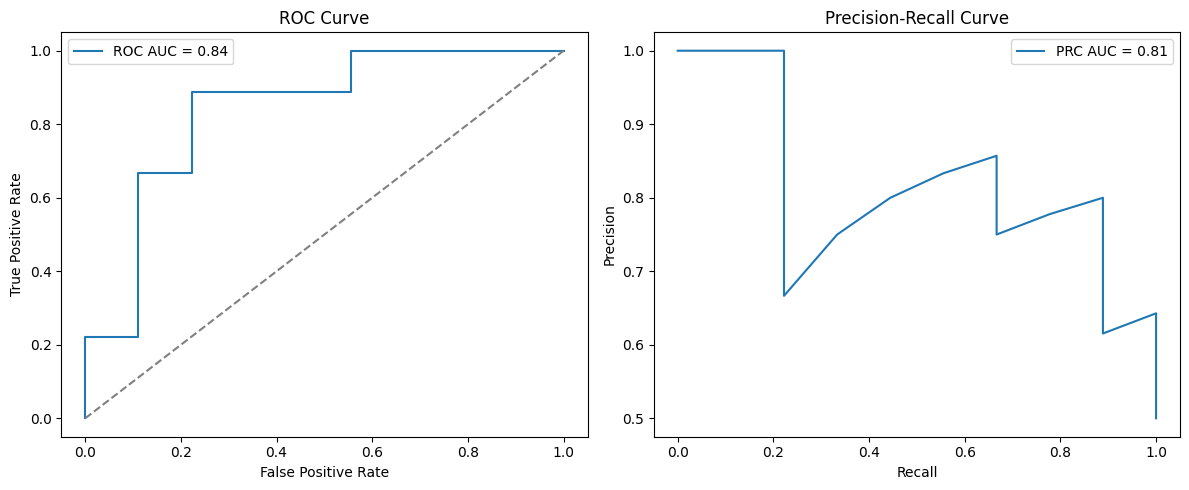

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_recall_curve,
    auc, cohen_kappa_score, roc_curve
)
import matplotlib.pyplot as plt
import joblib

# 1. Load the best pipeline model (if saved previously)
best_model_pipeline = joblib.load("final_pipeline_model.pkl")

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, stratify=y, random_state=42
)

# 3. Predict with the best model
y_pred = best_model_pipeline.predict(X_test)
y_proba = best_model_pipeline.predict_proba(X_test)[:, 1]

# 4. Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
prc_auc = auc(recall, precision)
kappa = cohen_kappa_score(y_test, y_pred)

# 5. Print metrics
print(f"Accuracy       : {accuracy:.4f}")
print(f"ROC AUC        : {roc_auc:.4f}")
print(f"PRC AUC        : {prc_auc:.4f}")
print(f"Cohen's Kappa  : {kappa:.4f}")

# 6. ROC and PRC plots
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PRC
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PRC AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig('img/grafik/roc_prc_curves.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()


### 📈 Test Seti Üzerinde Nihai Performans Değerlendirmesi

Nested cross-validation ve hiperparametre optimizasyonu ile seçilen **en iyi pipeline modeli**, ayrılmış test verisi üzerinde değerlendirilmiştir.  
Modelin performansı aşağıdaki metrikler ile analiz edilmiştir:

- **Doğruluk (Accuracy)**: %77.78  
- **ROC AUC**: 0.8395  
- **PRC AUC**: 0.8141  
- **Cohen’s Kappa**: 0.5556  

Bu sonuçlar, modelin tekrar sipariş verme olasılığı olan müşterileri ayırt etmede **tatmin edici bir performans** sergilediğini göstermektedir.  
ROC AUC ve PRC AUC değerleri, özellikle sınıf dengesizliğinin olduğu veri yapılarında **modelin ayrıştırma yeteneğinin güçlü** olduğunu göstermektedir.  

Cohen’s Kappa değerinin orta seviyede olması, modelin rastgele tahmine göre anlamlı bir şekilde daha iyi olduğunu ancak geliştirme potansiyeli taşıdığını da işaret etmektedir.

Sonuç olarak, bu test seti değerlendirmesi, nested CV süreci ile elde edilen modelin **gerçek dünya verisi üzerinde uygulanabilir ve güvenilir** olduğunu doğrulamaktadır.


### 📊 Veri Seti Analizi : En Aktif Müşteriler ve Çok Satan Ürünler

Veri setindeki satın alma davranışını daha iyi anlamak için aşağıdaki müşteri ve ürün analizleri görselleştirilmiştir:

1. **En Sık Sipariş Veren Müşteriler**  
   Tüm zamanlarda en çok sipariş veren ilk 10 müşteri.

2. **Son 6 Ayın En Aktif Müşterileri**  
   Son 6 aylık dönemde en fazla sipariş veren 10 müşteri (cutoff tarihine göre hesaplanmıştır).

3. **En Çok Harcayan Müşteriler**  
   En yüksek toplam harcamaya sahip 10 müşteri (`unit_price × quantity` üzerinden hesaplanmıştır).

4. **En Sık Sipariş Edilen Ürünler**  
   Tüm müşteriler arasında en sık sipariş edilen ilk 10 ürün.

Her grafik üzerine çubuk etiketleri yazdırılarak yorumlanabilirlik artırılmıştır.  
Bu analizler, özellik mühendisliği, müşteri segmentasyonu ve yüksek değerli müşteri/ürün belirleme açısından faydalıdır.


🔹 Most Frequent Customers
customer_id
SAVEA    31
ERNSH    30
QUICK    28
HUNGO    19
FOLKO    19
BERGS    18
RATTC    18
HILAA    18
BONAP    17
LEHMS    15
Name: order_id, dtype: int64


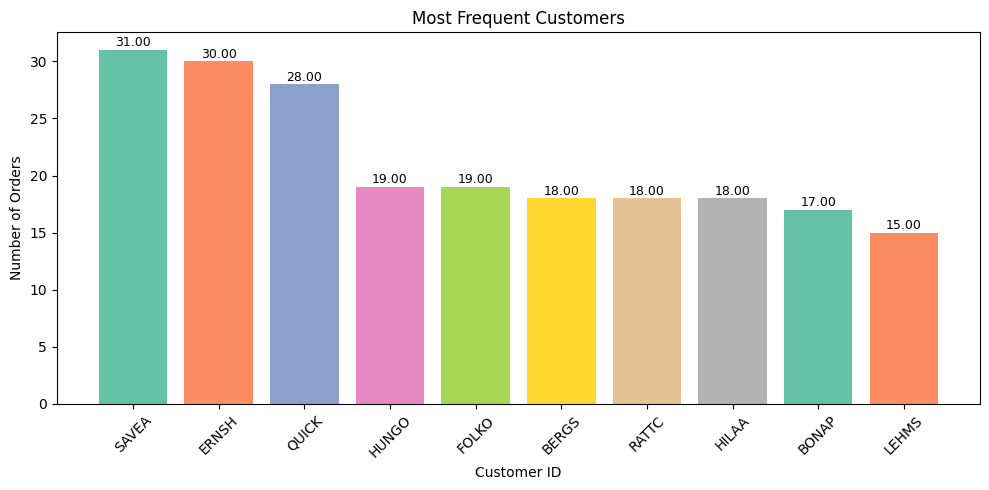


🔹 Most Active Customers (Last 6 Months)
customer_id
ERNSH    14
SAVEA    13
QUICK    11
FOLKO    11
HANAR     9
BOTTM     9
AROUT     8
LINOD     7
SUPRD     7
HILAA     7
Name: order_id, dtype: int64


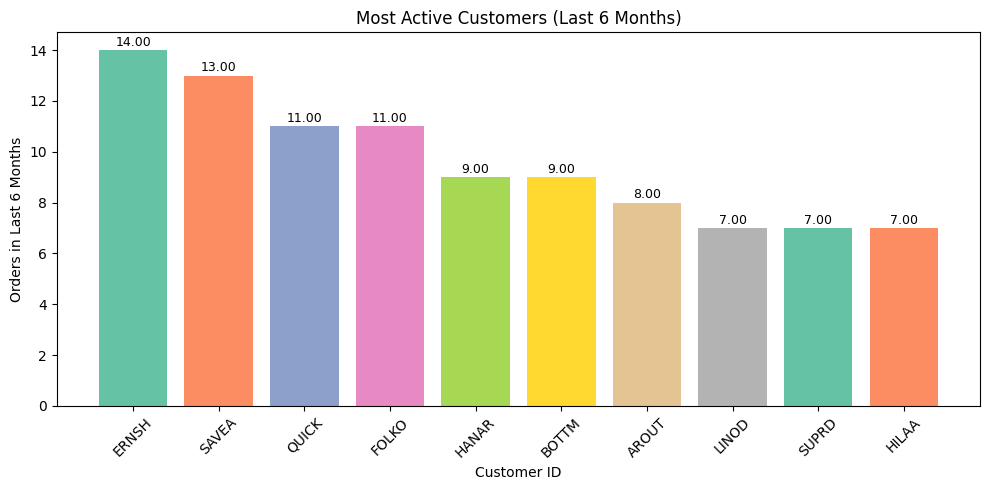


🔹 Top Spending Customers
customer_id
QUICK    117483.39
SAVEA    115673.39
ERNSH    113236.68
HUNGO     57317.39
RATTC     52245.90
HANAR     34101.15
FOLKO     32555.55
MEREP     32203.90
KOENE     31745.75
QUEEN     30226.10
Name: total_price, dtype: float64


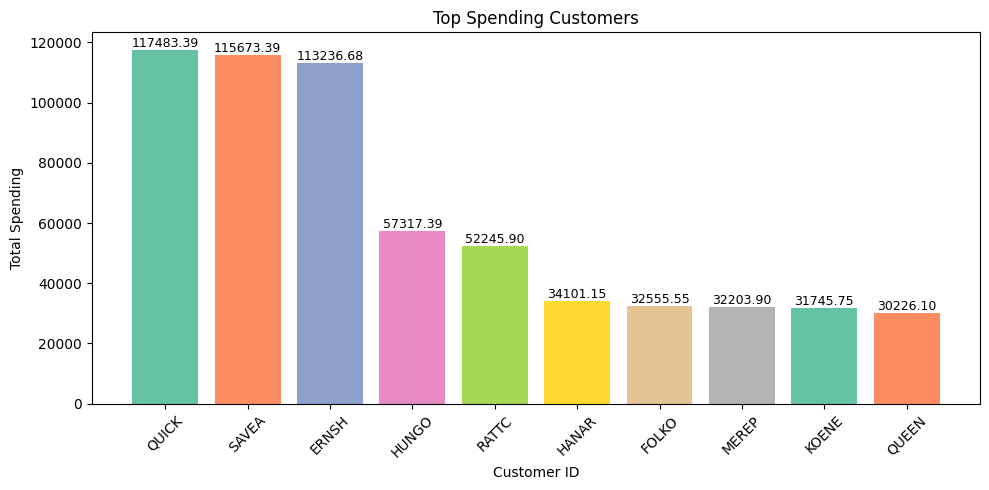


🔹 Most Frequently Ordered Products
product_id
59    54
60    51
31    51
24    51
56    50
62    48
41    47
75    46
2     44
16    43
Name: order_id, dtype: int64


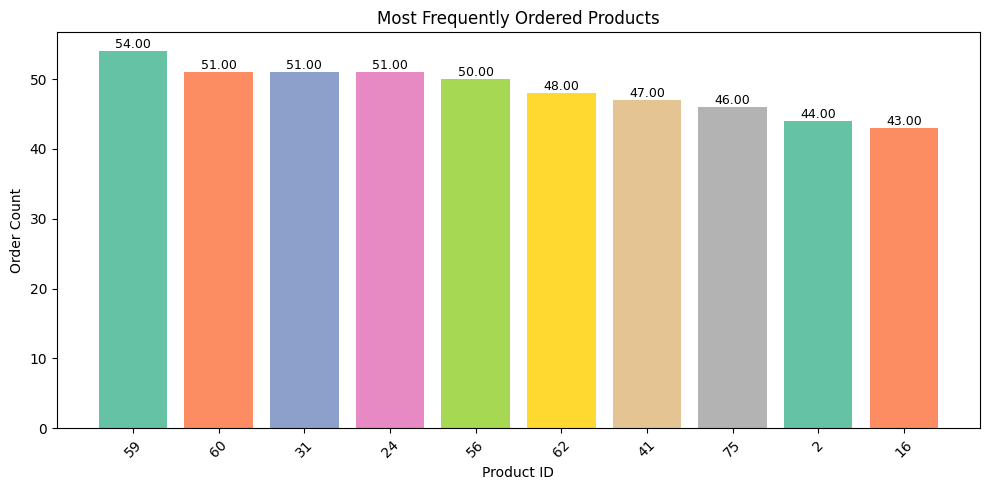

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


cutoff_date = df['order_date'].max()
six_months_ago = cutoff_date - pd.DateOffset(months=6)

top_customer_orders = df.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).head(10)
recent_df = df[df['order_date'] > six_months_ago]
top_recent_orders = recent_df.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).head(10)
top_total_spending = df.groupby('customer_id')['total_price'].sum().sort_values(ascending=False).head(10)
top_product_orders = df.groupby('product_id')['order_id'].count().sort_values(ascending=False).head(10)

colors = sns.color_palette("Set2", 10)

def plot_bar_with_labels(data, title, xlabel, ylabel, save_path=None):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(data.index.astype(str), data.values, color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}', 
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

# 🔹 Most Frequent Customers
print("\n🔹 Most Frequent Customers")
print(top_customer_orders)
plot_bar_with_labels(
    top_customer_orders,
    'Most Frequent Customers',
    "Customer ID",
    "Number of Orders",
    save_path='img/grafik/top_customer_orders.png'
)

# 🔹 Most Active Customers (Last 6 Months)
print("\n🔹 Most Active Customers (Last 6 Months)")
print(top_recent_orders)
plot_bar_with_labels(
    top_recent_orders,
    'Most Active Customers (Last 6 Months)',
    "Customer ID",
    "Orders in Last 6 Months",
    save_path='img/grafik/top_recent_orders.png'
)

# 🔹 Top Spending Customers
print("\n🔹 Top Spending Customers")
print(top_total_spending)
plot_bar_with_labels(
    top_total_spending,
    'Top Spending Customers',
    "Customer ID",
    "Total Spending",
    save_path='img/grafik/top_total_spending.png'
)

# 🔹 Most Frequently Ordered Products
print("\n🔹 Most Frequently Ordered Products")
print(top_product_orders)
plot_bar_with_labels(
    top_product_orders,
    'Most Frequently Ordered Products',
    "Product ID",
    "Order Count",
    save_path='img/grafik/top_product_orders.png'
)


### 📊 Son Siparişten Geçen Günlerin Dağılımı

Aşağıdaki histogram, **tekrar sipariş veren (y=1)** ve **vermeyen (y=0)** müşterilerin son sipariş tarihinden bu yana geçen gün sayılarını karşılaştırmaktadır.

Beklendiği gibi, tekrar sipariş veren müşterilerde bu sürenin **daha kısa** olduğu görülmekte; bu da yakın zamanda alışveriş yapmış olmanın güçlü bir işaret olduğunu göstermektedir.

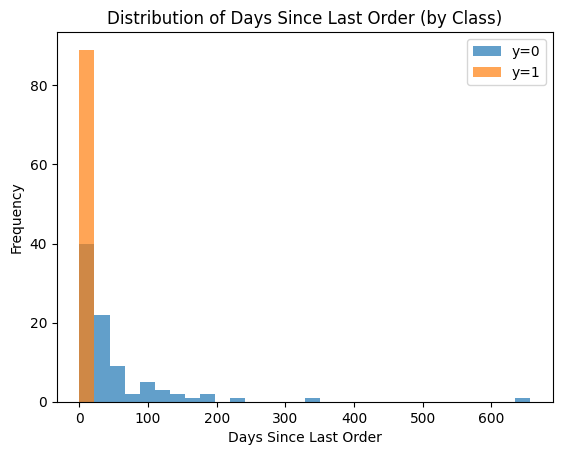

In [ ]:
features_df[['X4_days_since_last_order', 'target']].plot(
    kind='hist', bins=30, alpha=0.7, title='Distribution of Days Since Last Order (by Class)'
)
plt.xlabel("Days Since Last Order")
plt.legend(['y=0', 'y=1'])
plt.tight_layout()
plt.savefig('img/grafik/days_since_last_order_hist.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

### 📍 Harcama ve Sipariş Sıklığına Göre Müşteri Segmentasyonu

Aşağıdaki scatter plot, müşterilerin **harcama yoğunluğu** ve **sipariş sıklığına** göre dağılımını göstermektedir.  
Renkler, müşterinin tekrar sipariş verip vermediğini (`target = 1 veya 0`) temsil eder.

Grafikte, **yüksek sıklık ve harcama yoğunluğuna** sahip müşterilerin tekrar sipariş verme olasılığının daha yüksek olduğu görülmektedir. Bu da bu değişkenlerin öngörü gücünü desteklemektedir.

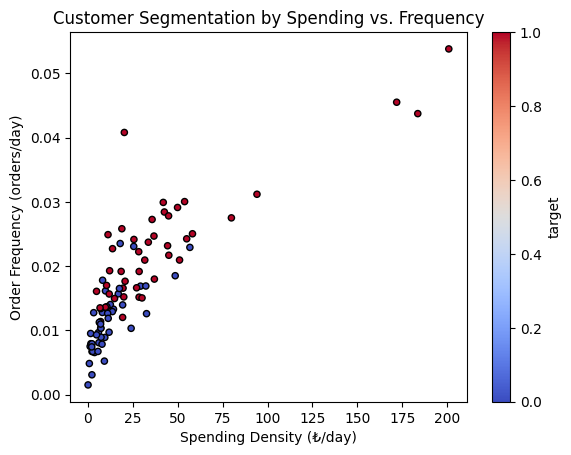

In [ ]:
features_df.plot.scatter(
    x='X6_spending_density_all_time', y='X5_order_frequency_all_time',
    c='target', cmap='coolwarm', edgecolor='k',
    title='Customer Segmentation by Spending vs. Frequency'
)
plt.xlabel("Spending Density (₺/day)")
plt.ylabel("Order Frequency (orders/day)")
plt.tight_layout()
plt.savefig('img/grafik/spending_vs_frequency_scatter.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()